# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import time
import csv
import itertools
import os
from scipy import ndimage
from tqdm import tnrange
%matplotlib inline

In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = '../../sdc/traffic-signs-data/train.p'
testing_file = '../../sdc/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Save Original Test for future evaluation
X_test_orig = X_test
y_test_orig = y_test

In [3]:
# Load Sign Names

def read_signnames(file):
    with open(file) as f:
        csvreader = csv.reader(f)
        header = next(csvreader)
        signnames = {}
        for row in csvreader:
            signnames[int(row[0])] = row[1]
        return signnames

signnames = read_signnames('signnames.csv')
print("Sign names loaded: len = ", len(signnames))

Sign names loaded: len =  43


In [4]:
print('X_train.shape =', X_train.shape)
print('y_train.shape =', y_train.shape)
print('X_test.shape =', X_test.shape)
print('y_test.shape =', y_test.shape)
print('image shape = ', X_train[0].shape)
# np.max(y_train)+1


X_train.shape = (39209, 32, 32, 3)
y_train.shape = (39209,)
X_test.shape = (12630, 32, 32, 3)
y_test.shape = (12630,)
image shape =  (32, 32, 3)


In [5]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = np.max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


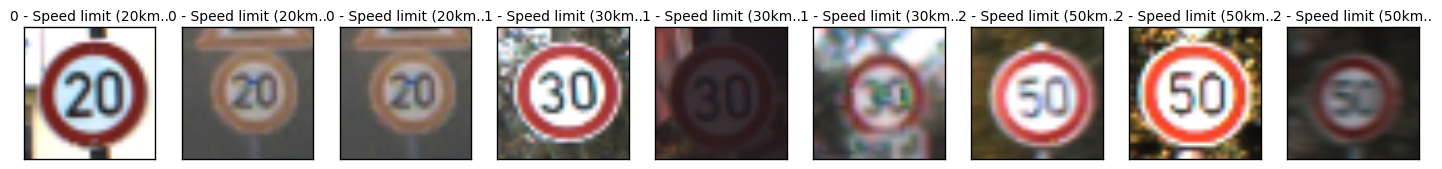

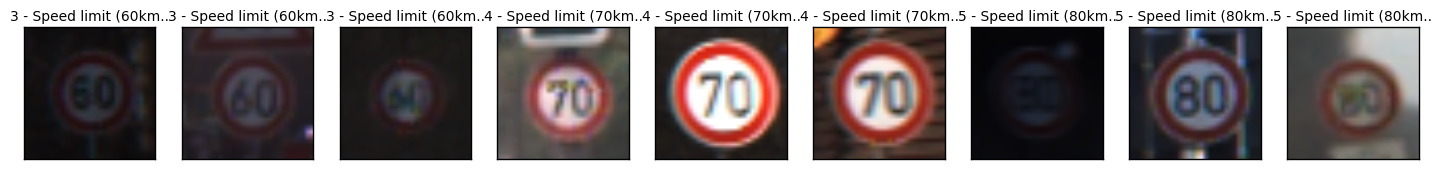

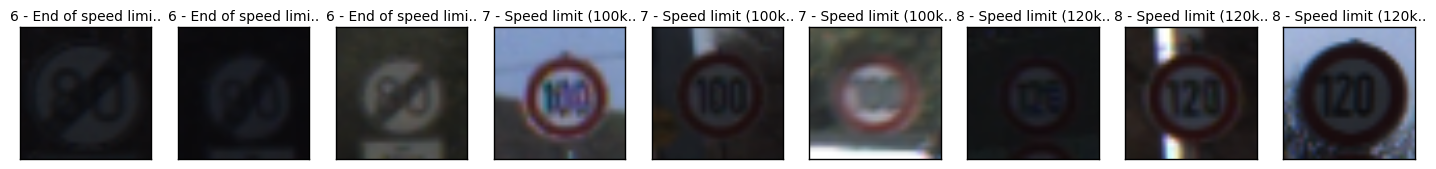

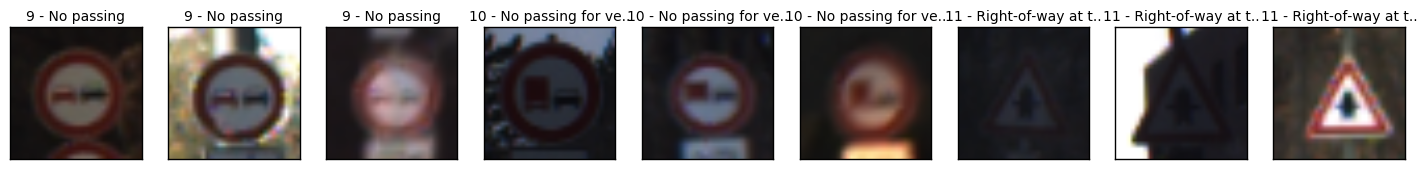

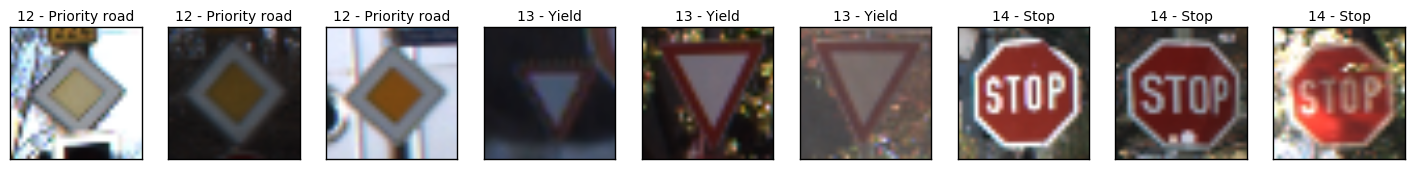

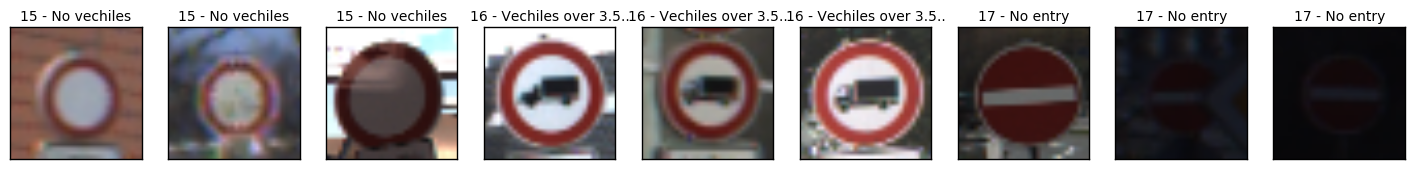

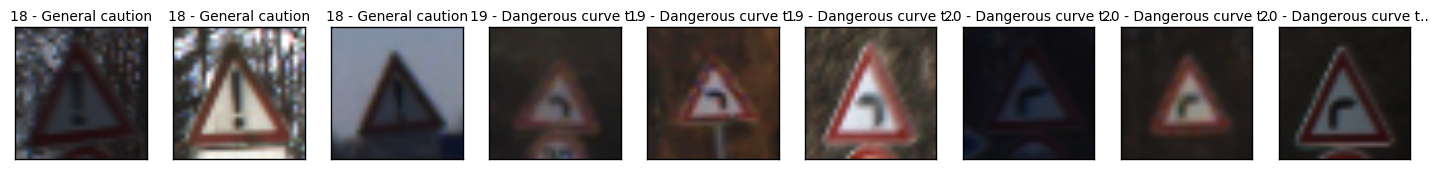

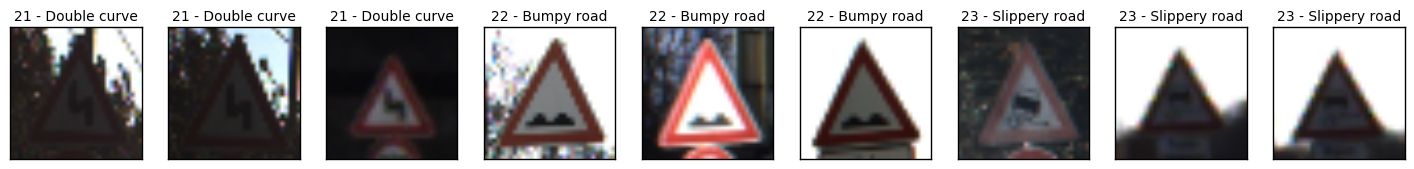

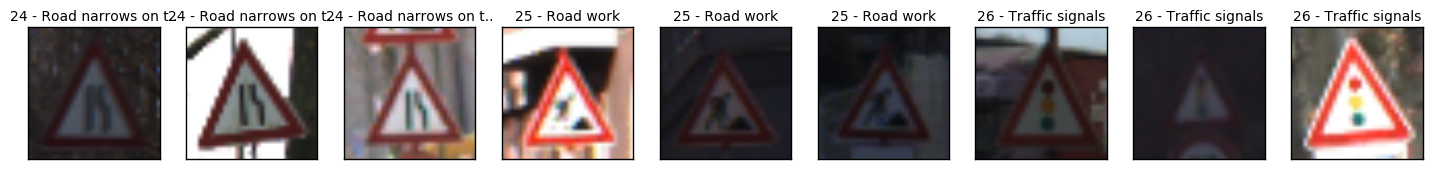

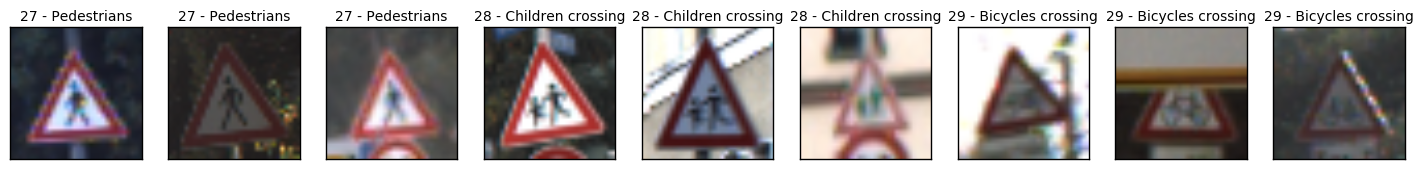

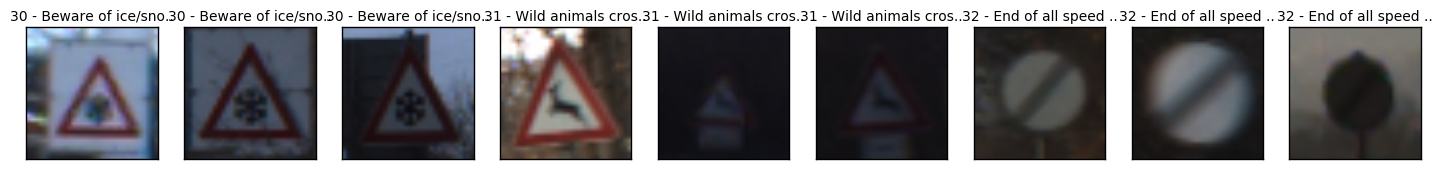

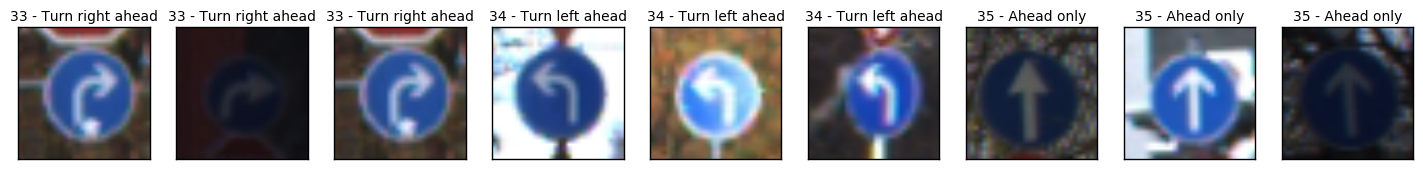

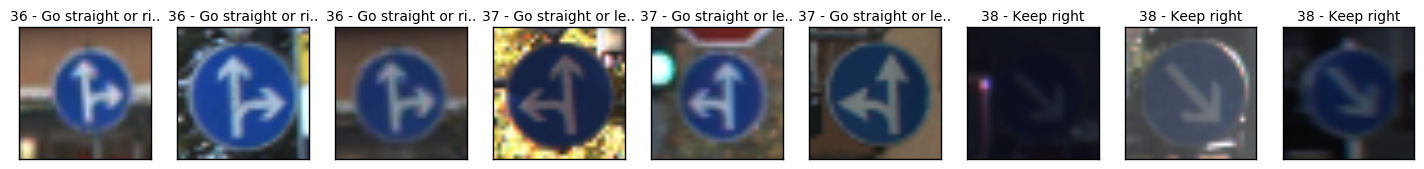

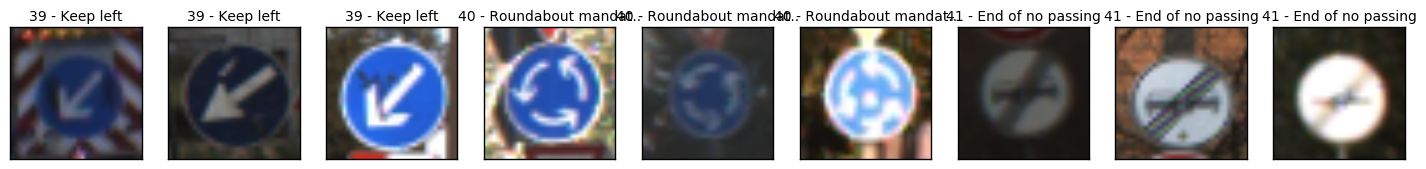

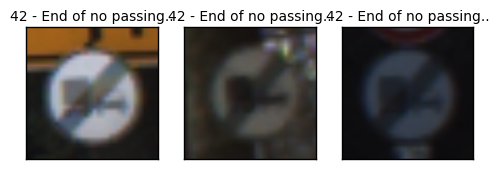

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.


# Show all classes
def show_all_classes(data, labels, num_line=9, num_imgs=3):
    for c in range(n_classes):
        if c * num_imgs % num_line == 0:
            plt.figure((c * num_imgs) // num_line, figsize=(18, 2))
        s = data[labels == c]
        indices = np.random.randint(0, len(s), num_imgs)

        for n, idx in enumerate(indices):
            plot_num = (c * num_imgs) % num_line + n + 1
            plt.subplot(1, num_line, plot_num)
            cur_axes = plt.gca()
            cur_axes.axes.get_xaxis().set_ticks([])
            cur_axes.axes.get_yaxis().set_ticks([])
            plt.imshow(s[idx])
            signname = signnames[c][:17] + '..' if len(signnames[c]) > 17 else signnames[c]
            plt.title('%d - %s' % (c, signname), fontsize=10)
            
show_all_classes(X_train, y_train)


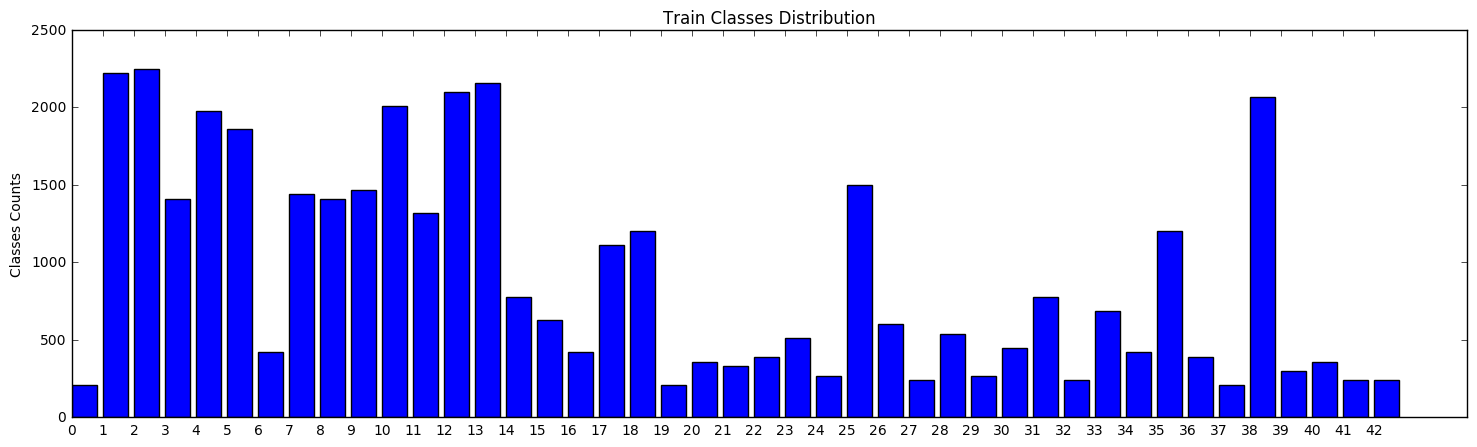

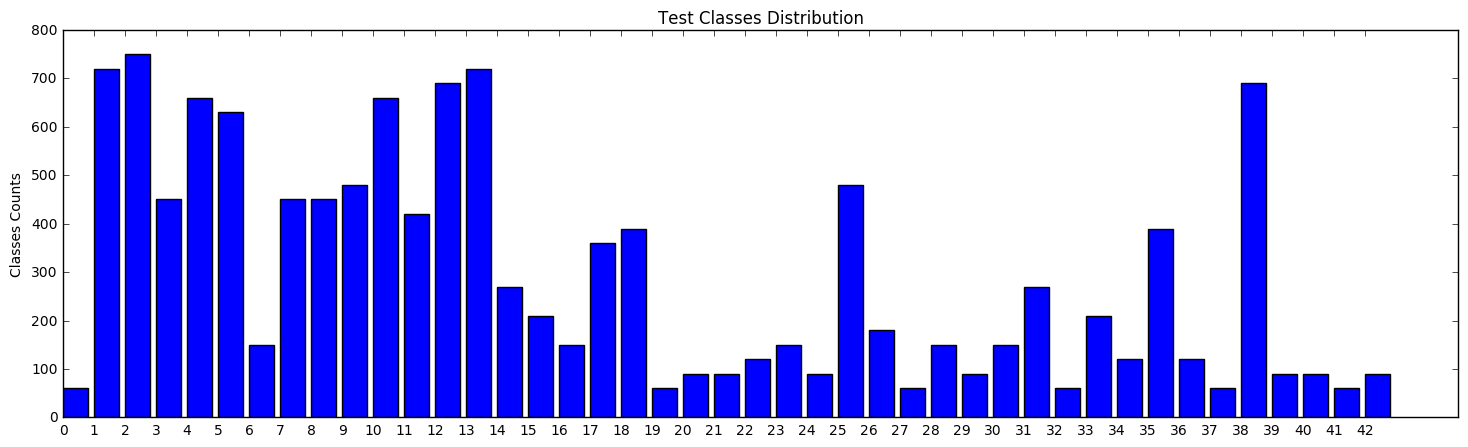

In [7]:
# Draw the classes distribution in X_train samples

def show_classes_distribution(labels, title = None):
    # Count classes samples
    uniq_labels = sorted(set(labels.tolist()))
    n_labels = len(uniq_labels)
    class_counts = np.zeros([n_labels])
    for c in uniq_labels:
        class_counts[c] = np.sum(labels == c)
    y_pos = np.arange(n_labels)
    plt.figure(figsize=(18, 5))
    plt.bar(uniq_labels, class_counts)
    plt.xticks(y_pos)
    plt.ylabel('Classes Counts')
    if title: plt.title(title)
    
show_classes_distribution(y_train, title='Train Classes Distribution')
show_classes_distribution(y_test, title='Test Classes Distribution')


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def data_to_grayscale(data):
    # Transform to grayscale
    shape = data.shape
    data_gray = np.zeros((shape[0], shape[1], shape[2]))
    for idx, image in enumerate(data):
        data_gray[idx] = grayscale(image)
    return data_gray


def random_rotate(img):
    angle = np.random.randint(-25, 25)
#     print('angle =', angle)
    return ndimage.rotate(img, angle, reshape=False)

def random_gaussian_filter(img):
    sigma = np.random.choice([0.2,0.5,0.7,1])
#     sigma = 0.5
#     print('sigma =', sigma)
    return ndimage.gaussian_filter(img, sigma=sigma)

def random_noise(img):
    noise = np.zeros_like(img)
    noise_lvl = np.random.choice([10, 20, 30])
    cv2.randn(noise, 0, noise_lvl.flatten())
#     print("noise =", noise)
    return img + noise

def random_image_transform(img):
    transforms = {
        0: random_rotate,
        1: random_gaussian_filter,
        2: random_noise
    }
    n = np.random.randint(3)
    im = transforms[n](img)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

    

"""
X_train_gray = data_to_grayscale(X_train)

# Show random images from X_train_gray
n_samples = 12
n_samples_idx = np.random.randint(0, len(X_train_gray), n_samples)
gray_samples = X_train_gray[n_samples_idx]
plt.figure(figsize=(18, 5))
for n, img in enumerate(gray_samples):
    plt.subplot(1, n_samples, n + 1)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])
    plt.imshow(img, cmap='gray')
"""


"\nX_train_gray = data_to_grayscale(X_train)\n\n# Show random images from X_train_gray\nn_samples = 12\nn_samples_idx = np.random.randint(0, len(X_train_gray), n_samples)\ngray_samples = X_train_gray[n_samples_idx]\nplt.figure(figsize=(18, 5))\nfor n, img in enumerate(gray_samples):\n    plt.subplot(1, n_samples, n + 1)\n    cur_axes = plt.gca()\n    cur_axes.axes.get_xaxis().set_ticks([])\n    cur_axes.axes.get_yaxis().set_ticks([])\n    plt.imshow(img, cmap='gray')\n"

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Preprocessing included:
- normalization - important step that I missed firstly and get a vanishing gradient descent problem when softmax exploded and everything was 0 but just one class
- train/validation/test separation - I've combined train/test into one data set and then split it into train - 60%, validation - 20%, test - 20%
- generate additional images: random rotation (angle in [-25,25]), random gaussian filter and random noise level. All was implemented with cv2 library
- additional images was added to underrepresented classes in order to smooth the distribution of samples

NOTE: On a convolutional model without additional data and training on 55 epochs I've received Accuracy about 99.16% on a test dataset.


In [9]:
# Combine train and test into one dataset
# X = X_train
# y = y_train

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)


len_X = 51839
len_y = 51839
class_counts = [  270.  2940.  3000.  1860.  2640.  2490.   570.  1890.  1860.  1950.
  2670.  1740.  2790.  2880.  1050.   840.   570.  1470.  1590.   270.
   450.   420.   510.   660.   360.  1980.   780.   300.   690.   360.
   600.  1050.   300.   899.   540.  1590.   510.   270.  2760.   390.
   450.   300.   330.]
max_num = 3000.0
min_num = 270.0

errors = 0
len_X = 129000
len_y = 129000


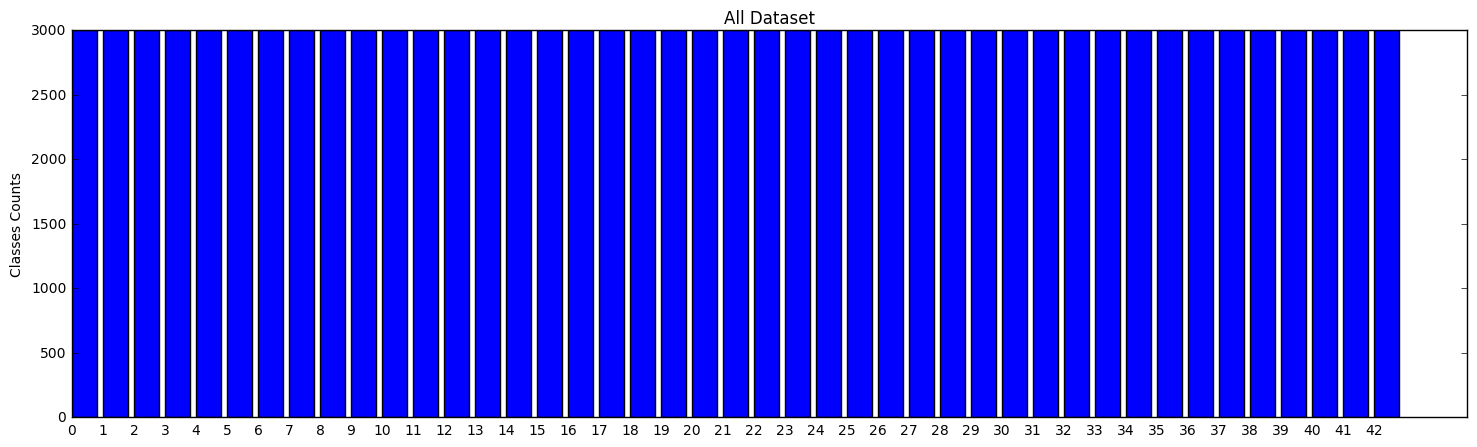

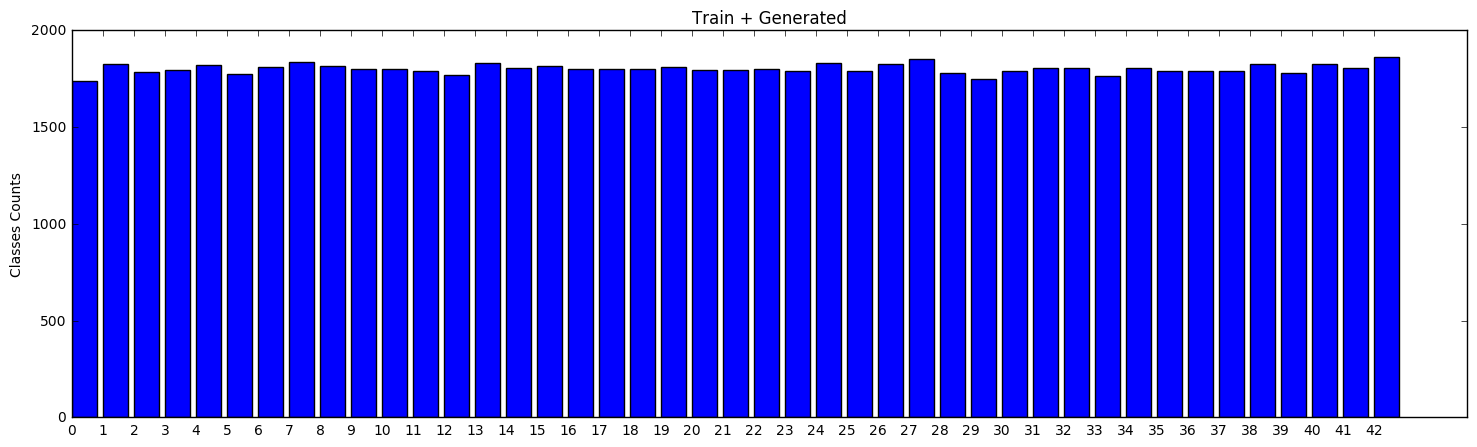

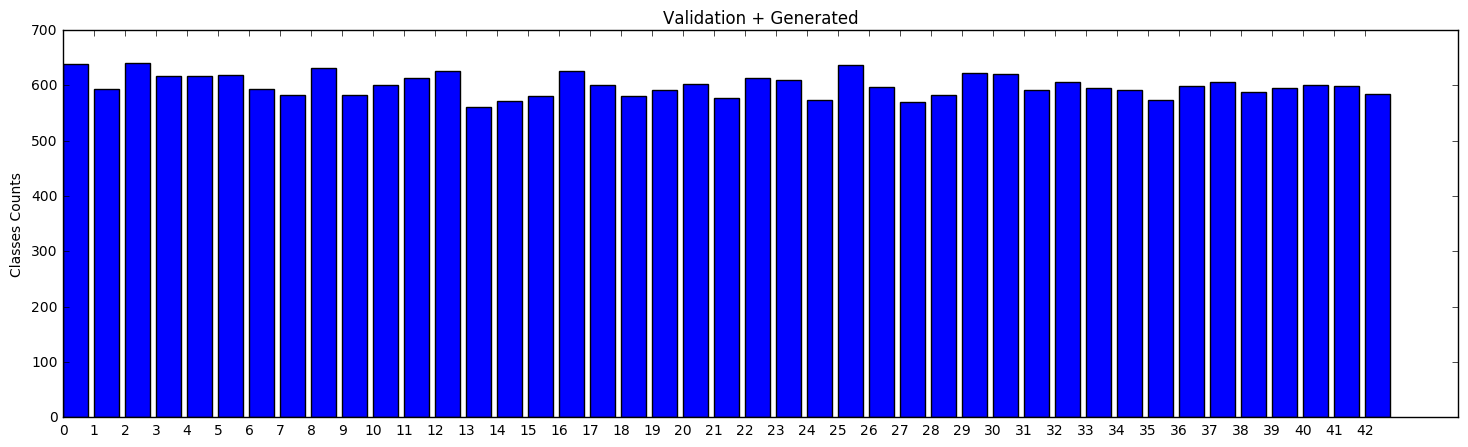

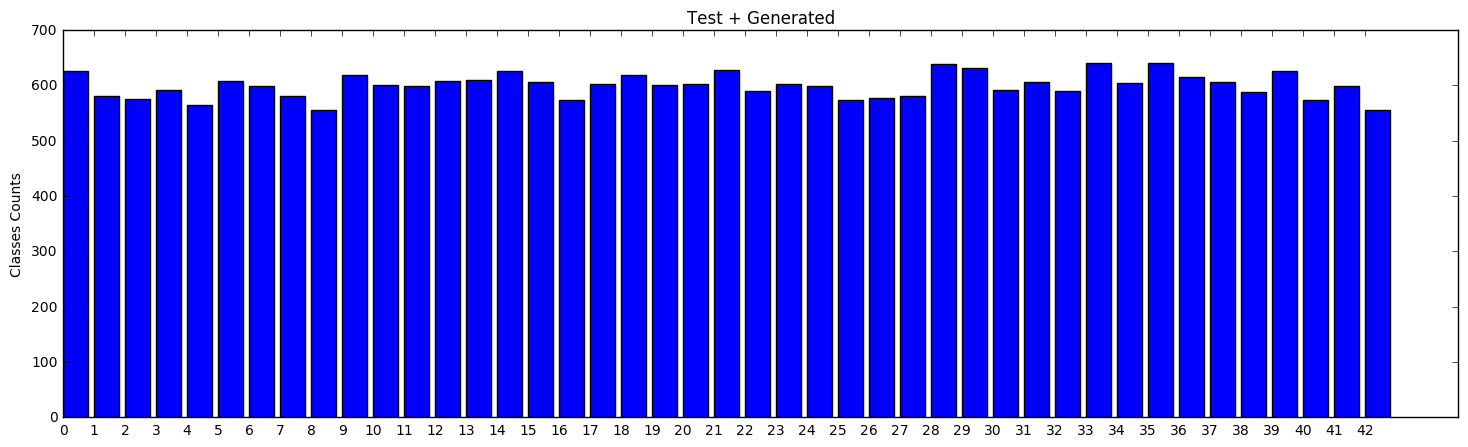

In [25]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Generate additional data hints
# real-world variabilities such as viewpoint variations, lighting conditions
# (saturations, low-contrast), motion-blur, occlusions, sun
# glare, physical damage, colors fading, graffiti, stickers and
# an input resolution as low as 15x15



def generate_additional_images(X, y):
    # Count classes samples
    uniq_labels = sorted(set(y.tolist()))
    n_labels = len(uniq_labels)
    class_counts = np.zeros([n_labels])
    
    all_ind = np.arange(len(y))
    img_indices = {}
    for c in uniq_labels:
        class_counts[c] = np.sum(y == c)
        img_indices[c] = all_ind[y == c]
    
    print("len_X =", len(X))
    print("len_y =", len(y))
    print("class_counts =", class_counts)
        
    max_num = np.max(class_counts)
    min_num = np.min(class_counts)
    print("max_num =", max_num)
    print("min_num =", min_num)

    errors = 0
    
    classes_range = tnrange(n_labels, desc="Classes") # tqdm progress
    
    for c in classes_range:
        c_num = np.sum(y == c)
        num = max_num - c_num
#         print('%2d: c_num = %d, num = %d' % (
#             c, c_num, num))
        nimgs = []
        nimgs_labels = []
        
#         num_range = tnrange(int(num), desc="C=%d" % c) # tqdm progress
        num_range = range(int(num)) # tqdm progress
        
        for n in num_range:
            # Draw random image of class argmin
            sample = np.random.choice(img_indices[c])
#             print("sample =", sample)
            # Transform it
            try:
                nimg = random_image_transform(X[sample])
            except:
                errors += 1
                nimg = random_gaussian_filter(X[sample])
#                 continue
#                 print('Error! c = %d, sample = %d' % (c, sample))
            # Append to X and append to y
            nimgs.append(nimg)
            nimgs_labels.append(c)
            
        if len(nimgs) > 0:
#             print("1: len_X =", len(X))
#             print("1: X.shape =", X.shape)
#             print("1: len_nimgs =", len(nimgs))
    #         print("1: nimgs.shape =", nimgs[0].shape)
            X = np.append(X, np.array(nimgs), axis=0)
#             print("1: len_X =", len(X))
#             plt.imshow(nimgs[0])
            y = np.append(y, nimgs_labels)
            class_counts[c] += num

            
#             
#         print("all_ind =", img_indices[c])
#         print("sample =", np.random.choice(img_indices[c]))
#         max_num - min_num > 0.1 * max_num
        # add sample of class argmin
#         argmin = np.argmin(class_counts)
#         print("argmin =", argmin)
        
        
        # Append to X and append to y
        # +1 to class_counts
#         max_num = np.max(class_counts)
#         min_num = np.min(class_counts)
#         print("max_num =", max_num)
#         print("min_num =", min_num)
#         break
        
#     print("len_X =", len(X))
#     print("len_y =", len(y))
#     print("class_counts =", class_counts)
    print("errors =", errors)
    return X, y
    
X1, y1 = generate_additional_images(X, y)
show_classes_distribution(y1, 'All Dataset')

# Visualize sample of each class
# show_all_classes(X1, y1, num_line=6, num_imgs=1)


# Split Data into Train/Validation/Test
def train_validation_test(X, y):
    # Shuffle it
    r_idx = np.random.permutation(len(X))
    print("len_X =", len(X))
    print("len_y =", len(y))
#     print("r_idx =", r_idx)
    X = X[r_idx]
    y = y[r_idx]

    # Train/Valid/Test distributions
    p_train = 0.6
    p_valid = 0.2
    p_test = 0.2

    # Sanity check
    assert p_train + p_valid + p_test == 1.0
#     assert p_train + p_valid == 1.0

    N = len(X)
    train_idx = int(N*p_train)
    valid_idx = int(N*(p_train+p_valid))
    X_train = X[:train_idx]
    y_train = y[:train_idx]
    X_valid = X[train_idx:valid_idx]
    y_valid = y[train_idx:valid_idx]
    X_test = X[valid_idx:]
    y_test = y[valid_idx:]

#     X_test = X[valid_idx:]
#     y_test = y[valid_idx:]
                
    assert len(X_train) + len(X_valid) + len(X_test) == N
    assert len(y_train) + len(y_valid) + len(y_test) == N
#     assert len(X_train) + len(X_valid) == N
#     assert len(y_train) + len(y_valid) == N

    
    return X_train, y_train, X_valid, y_valid, X_test, y_test
#     return X_train, y_train, X_valid, y_valid

X_train, y_train, X_valid, y_valid, X_test, y_test = train_validation_test(X1, y1)
# X_train, y_train, X_valid, y_valid = train_validation(X1, y1)

show_classes_distribution(y_train, 'Train + Generated')
show_classes_distribution(y_valid, 'Validation + Generated')
show_classes_distribution(y_test, 'Test + Generated')

In [11]:
# plt.imshow(random_rotate(X[3756]))

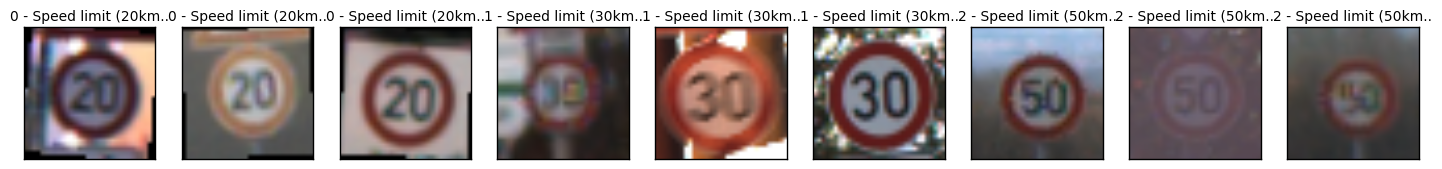

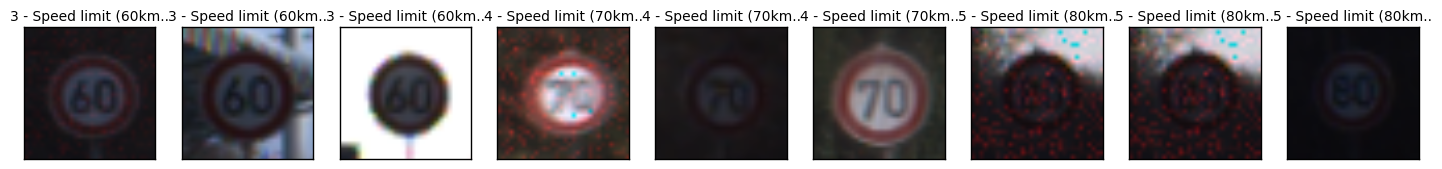

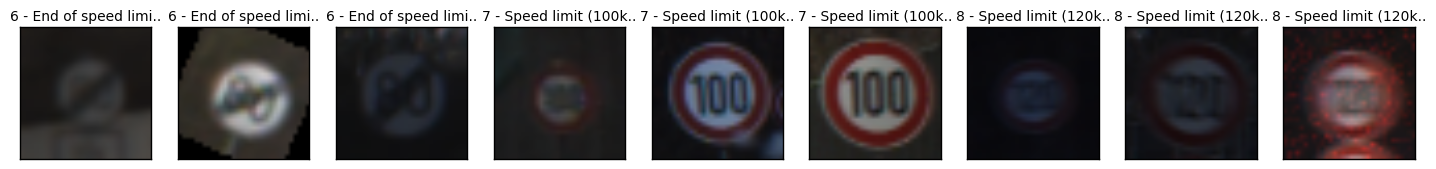

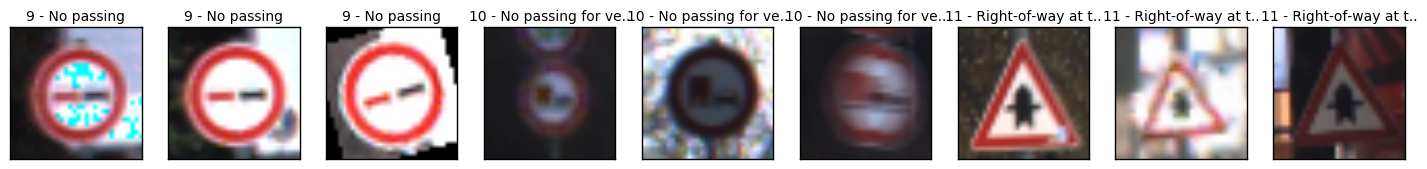

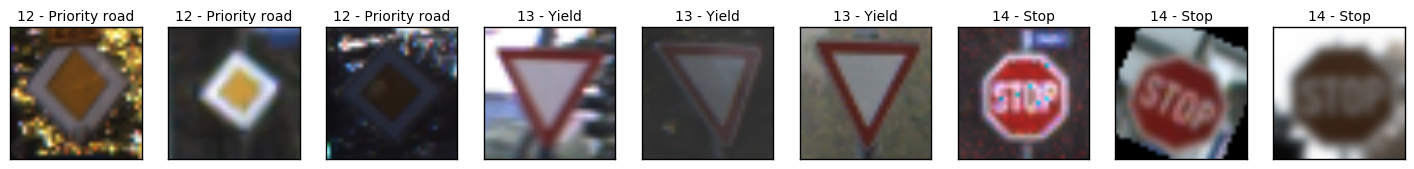

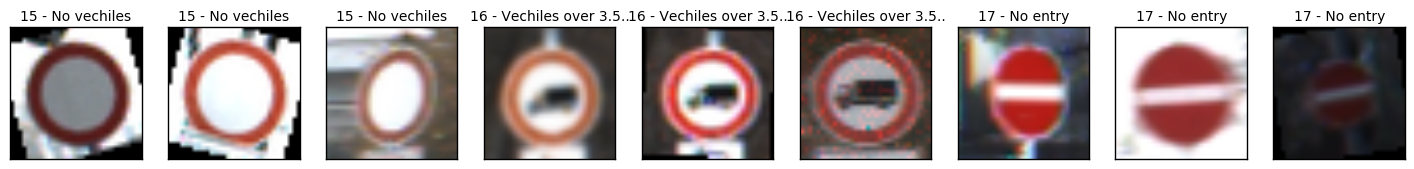

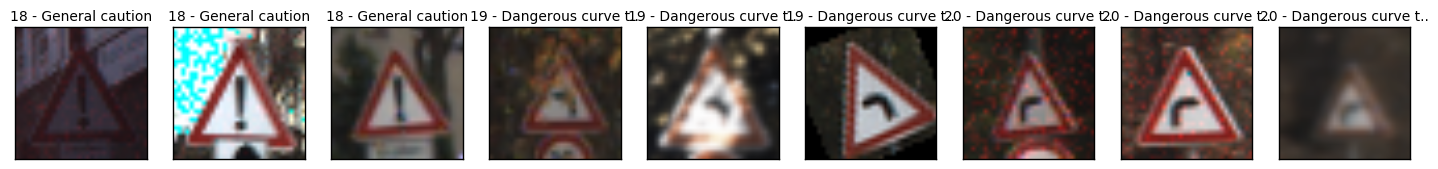

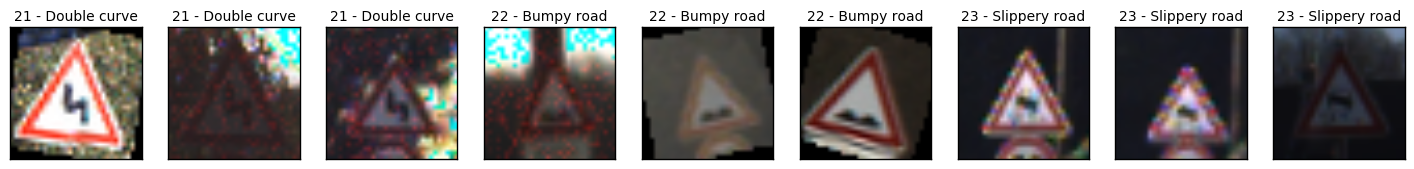

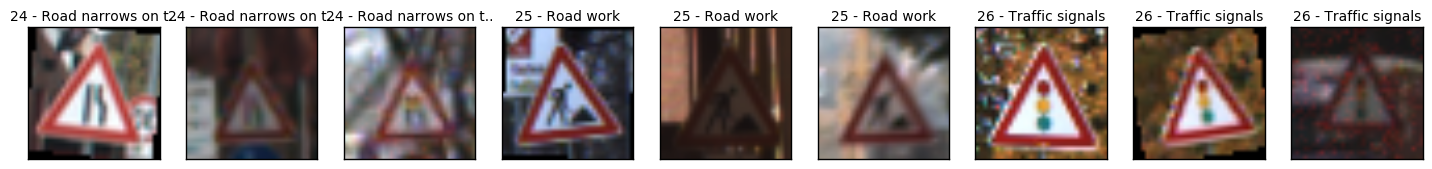

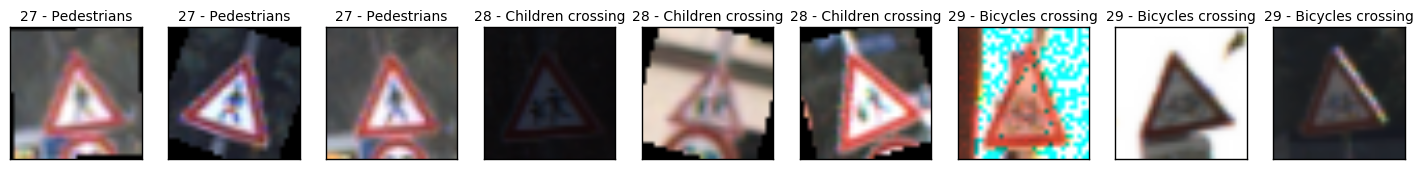

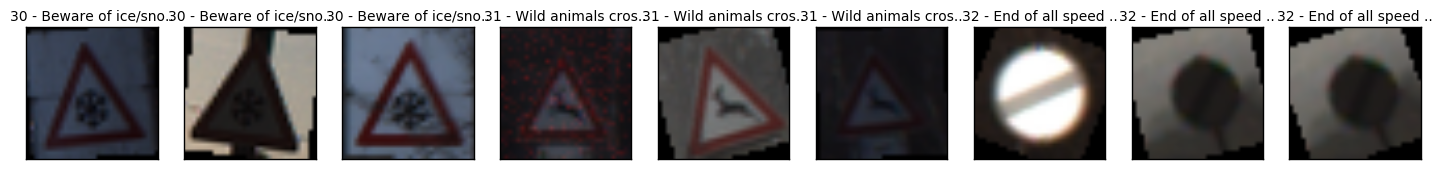

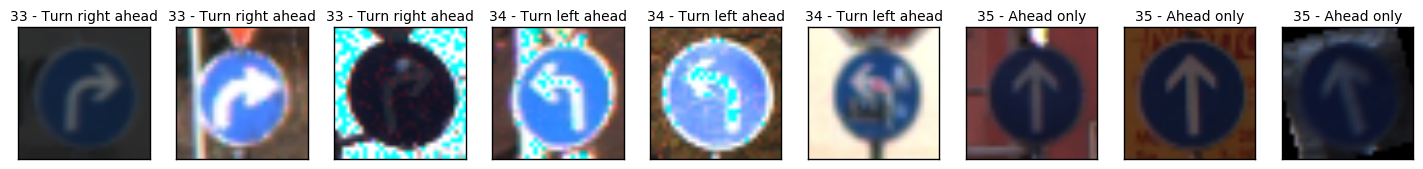

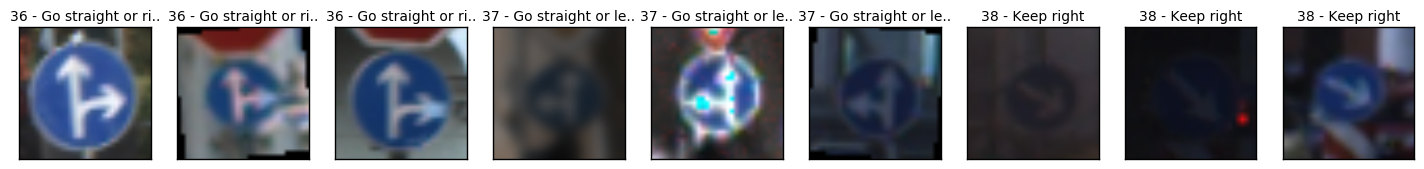

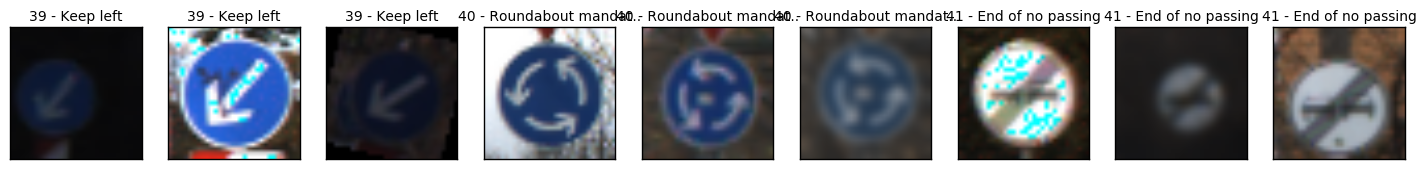

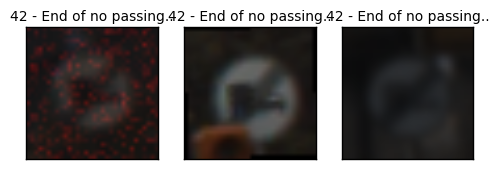

In [12]:
# Visualize sample of each class
show_all_classes(X_train, y_train, num_line=9, num_imgs=3)


In [29]:
# Normalize data
def normalize(data):
    pixel_depth = 255
    return (data - pixel_depth / 2) / pixel_depth

X_train_norm = normalize(X_train)
X_valid_norm = normalize(X_valid)
X_test_norm = normalize(X_test)

X_test_orig_norm = normalize(X_test_orig)

print("Data normalized.")

# print("X_train[0] =", X_valid[0])

Data normalized.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

As I've described earlier additional added could help us to add more samples on classes with a small number of train data (compared to other classes) so to get an even distribution of samples among classes. In case of skewed datasets where some classes don't have enough data we can get a model that is not going to work good on this classes (in infer mode) due to small number of training samples.

Accuracy of the model is better when trained on a set with generated images **99.34%** vs **99.16%**

In [14]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [15]:
# Config

class SmallConfig(object):
    """Small config. """
    # init_scale = 0.1
    image_size = 32
    num_classes = 43
    num_channels = 3
    fc1_size = 512
    batch_size = 128 # 128
    max_epoch = 55 # 250 45 55 - latest
    keep_prob = 0.5
    lr = 0.01
    lr_decay = 0.95
    train_size = X_train.shape[0]


In [30]:
# Model Define

class SignsModel(object):
    """Road Sign Classifier"""
    
    def __init__(self, config):
        self.batch_size = config.batch_size
        self.image_size = config.image_size
        self.num_classes = config.num_classes
        self.num_channels = config.num_channels
        
        self.train_size = config.train_size
        
        self.config = config
        
        self.add_placeholders()
        
        self.output_logits = self.add_model()
        
        self.loss = self.add_loss_op(self.output_logits)
        
        self.train_op = self.add_training_op(self.loss)
        
        self.prediction = self.add_prediction(self.output_logits)
    
    def add_placeholders(self):
        """Add Placeholders"""
        self.input_placeholder = tf.placeholder(tf.float32,
                                                shape=[None, self.image_size, self.image_size, self.num_channels],
                                                name="Inputs")
        self.labels_placeholder = tf.placeholder(tf.int64, shape=[None,], name="Labels")
        self.dropout_placeholder = tf.placeholder(tf.float32, name="Dropout")
    
    def add_model(self):
        """Model Definition"""

        fc1_size = self.config.fc1_size
        
        self.params = {}

        
        conv1_depth = 32
        conv2_depth = 64
        
        # Define variables
        self.params["conv1_weights"] = conv1_weights = tf.Variable(
            tf.truncated_normal([5, 5, self.num_channels, conv1_depth],
                                stddev=0.1,
                                dtype=tf.float32), name="conv1_weights")
        self.params["conv1_biases"] = conv1_biases = tf.Variable(tf.zeros([conv1_depth], dtype=tf.float32),
                                                                name="conv1_biases")
        
        self.params["conv2_weights"] = conv2_weights = tf.Variable(
            tf.truncated_normal([5, 5, conv1_depth, conv2_depth],
                                stddev=0.1,
                                dtype=tf.float32), name="conv2_weights")
        self.params["conv2_biases"] = conv2_biases = tf.Variable(tf.zeros([conv2_depth], dtype=tf.float32),
                                                                name="conv2_biases")

        
        self.params["W1"] = W1 = tf.Variable(tf.truncated_normal([self.image_size // 4 * self.image_size // 4 * conv2_depth, self.num_classes]), name="W1")
        self.params["b1"] = b1 = tf.Variable(tf.truncated_normal([self.num_classes]), "b1")
        
        # Define ops
        
        # Conv Layer 1
        conv = tf.nn.conv2d(self.input_placeholder,
                            conv1_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        
        # Conv Layer 2
        conv = tf.nn.conv2d(pool,
                            conv2_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')

        
        # Reshape for fully connected layers
        pshape = pool.get_shape().as_list()
        pool_line = tf.reshape(pool, [-1, pshape[1] * pshape[2] * pshape[3]])
        
        # Used only during training by setting dropout param to config.keep_prob
        pool_line = tf.nn.dropout(pool_line, self.dropout_placeholder)
        
        output = tf.matmul(pool_line, W1) + b1
      
        return output

        
    def add_loss_op(self, output):
        """Loss Op"""
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                output, self.labels_placeholder))

        # Regularization
        regularizers = tf.nn.l2_loss(self.params['W1']) + tf.nn.l2_loss(self.params['b1'])
        loss += 5e-4 * regularizers

        return loss
        
    def add_training_op(self, loss):
        """Add Training Op"""
        self.global_step = tf.Variable(0, dtype=tf.float32, name="global_step")
        self.learning_rate = tf.train.exponential_decay(
            self.config.lr,
            self.global_step * self.config.batch_size,
            self.train_size, # Train size
            self.config.lr_decay,
            staircase=True
        )
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.minimize(loss, global_step=self.global_step)
        return train_op
    
    def add_prediction(self, output):
        prediction = tf.nn.softmax(output)
        return prediction
    
    def eval_predictions(self, session, data):
        batch_size = self.config.batch_size
        num_classes = self.config.num_classes
        size = data.shape[0]
        
        if size < batch_size:
            feed_dict = {
                    self.input_placeholder: data,
                    self.dropout_placeholder: 1.0
            }
            return session.run(self.prediction, feed_dict=feed_dict)

        predictions = np.ndarray(shape=(size, num_classes), dtype=np.float32)
        
        steps_range = tnrange(0, size, batch_size, desc="Eval pred") # tqdm progress
        
        for begin in steps_range:
            end = begin + batch_size
            if end <= size:
                feed_dict = {
                    self.input_placeholder: data[begin:end],
                    self.dropout_placeholder: 1.0
                }
                predictions[begin:end, :] = session.run(self.prediction,
                                                        feed_dict=feed_dict)
            else:
                feed_dict = {
                    self.input_placeholder: data[-batch_size:],
                    self.dropout_placeholder: 1.0
                }
                batch_predictions = session.run(self.prediction,
                                               feed_dict=feed_dict)
                predictions[begin:] = batch_predictions[begin - size]
        return predictions
    
    def eval_prediction_labels(self, session, data):
        predictions = self.eval_predictions(session, data)
        return np.argmax(predictions, axis=1)
    
    def eval_prediction_labels_k(self, session, data, k=1):
        predictions = self.eval_predictions(session, data)
        values, indices = session.run(tf.nn.top_k(predictions, k=k))
        return values, indices
    
    def eval_accuracy(self, session, data, labels):
        predictions = self.eval_predictions(session, data)
        sum_ones = np.sum(np.argmax(predictions, axis=1) == labels)
        print("sum_ones =", sum_ones, " of len =", len(predictions))
        accuracy = sum_ones / len(predictions)
        return accuracy
    
    def run_epoch(self, session, data, labels, train_op = None, verbose = None):
        config = self.config
        batch_size = config.batch_size
        keep_prob = config.keep_prob
        num_steps = len(data) // batch_size
        
        if not train_op:
            train_op = tf.no_op()
            keep_prob = 1.0
            print("keep_prob =", keep_prob)
            steps_range = tnrange(num_steps, desc="Eval") # tqdm progress
        else:
            steps_range = tnrange(num_steps, desc="Steps") # tqdm progress
        
        total_loss = []
        for step in steps_range:
            x = data[step*batch_size:(step+1)*batch_size]
            y = labels[step*batch_size:(step+1)*batch_size]
            
            feed_dict = {
                self.input_placeholder: x,
                self.labels_placeholder: y,
                self.dropout_placeholder: keep_prob
            }
            _, loss, prediction = session.run([train_op, self.loss, self.prediction], feed_dict=feed_dict)
#             print("- conv =", conv)
#             print("- loss =", loss)
#             print("- logits =", logits)
#             print("- prediction =", prediction)
#             print("- prediction1 =", prediction[:, np.argmax(prediction, axis=1)])
#             print("- prediction max =", np.argmax(prediction, axis=1))
#             print("- y =", y)
            total_loss.append(loss)
#             print("loss =", loss)
            if verbose is not None and (step + 1) % verbose == 0:
                print("%d/%d loss = %f" % (step, num_steps, np.mean(total_loss)))
#             if step > 80: break
            
        return np.mean(total_loss)
    
    
    def train_model(self, session, train_data, train_labels, valid_data, valid_labels):
        max_epoch = self.config.max_epoch
        
        total_train_loss = []
        total_valid_loss = []
        epoch_valid_loss = 0
        for epoch in tnrange(max_epoch, desc="Epochs"):
            
            epoch_train_loss = self.run_epoch(session, train_data, train_labels, train_op = self.train_op, verbose = 20)
            total_train_loss.append(epoch_train_loss)
            
            epoch_valid_loss = self.run_epoch(session, valid_data, valid_labels)
            total_valid_loss.append(epoch_valid_loss)
            
            if epoch % 1 == 0 or epoch + 1 == max_epoch:
                print("Epoch %d/%d: " % (epoch + 1, max_epoch))
                print("Loss: %f" % epoch_train_loss)
                print("Validation Loss = %f" % (epoch_valid_loss))
                lr = session.run(self.learning_rate)
                print("LR =", lr)

                
        x_lab = np.arange(max_epoch)
        
        fig, ax = plt.subplots()
        ax.plot(x_lab, total_train_loss, '', label='Train Loss')
        ax.plot(x_lab, total_valid_loss, '', label='Valid Loss')
        ax.legend(loc='upper right')
        ax.set_title("Loss over Epochs")
        plt.show()
        
            
        return epoch_valid_loss
            
            
            
print("X_train_norm.shape =", X_train_norm.shape)
print("y_train_norm.shape =", y_train.shape)
print("X_valid_norm.shape =", X_valid_norm.shape)
print("y_valid_norm.shape =", y_valid.shape)
print("X_test_norm.shape =", X_test_norm.shape)
print("y_test_norm.shape =", y_test.shape)
   
# Reset graph so to have each time the same variable (useful for store/restore)
tf.reset_default_graph()
        
config = SmallConfig()
# config.lr = 0.005 # for additional training only
model = SignsModel(config)

# To train model from scratch change this to False
restore = True
restore_file = 'params/model_params_201611251155.ckpt' # 55 epoch w generated

# Switch to True if to train more epochs
train_more = False

# Create a session
session = tf.Session()
saver = tf.train.Saver(write_version=1)

# Restore or Initialize params
if restore and restore_file:
    saver.restore(session, restore_file)
    print("Model restored from ", restore_file)
    
    if train_more:
        model.config.max_epoch = 10
        print("Additional training for %d ecpochs ..." % model.config.max_epoch)
        model.train_model(session, X_train_norm, y_train, X_valid_norm, y_valid)

        save_time = time.strftime("%Y%m%d%H%M")
        saved_path = saver.save(session, "model_params_%s.ckpt" % save_time)
        print("Model params saved to ", saved_path)
    
else:
    # Init new
    all_variables = tf.all_variables()
    init = tf.initialize_variables(all_variables)
    session.run(init)
    
    print("Initialized new model params.")
    print("Train new model ...")
    model.train_model(session, X_train_norm, y_train, X_valid_norm, y_valid)
    
    save_time = time.strftime("%Y%m%d%H%M")
    saved_path = saver.save(session, "model_params_%s.ckpt" % save_time)
    print("Model params saved to ", saved_path)



print("Checking model test accuracy:")
accuracy = model.eval_accuracy(session, X_test_norm, y_test)
print("Test Accuracy = %.4f" % accuracy)

print("Checking model test orig accuracy:")
accuracy = model.eval_accuracy(session, X_test_orig_norm, y_test_orig)
print("Test Orig Accuracy = %.4f" % accuracy)




X_train_norm.shape = (77400, 32, 32, 3)
y_train_norm.shape = (77400,)
X_valid_norm.shape = (25800, 32, 32, 3)
y_valid_norm.shape = (25800,)
X_test_norm.shape = (25800, 32, 32, 3)
y_test_norm.shape = (25800,)
Model restored from  params/model_params_201611251155.ckpt
Checking model test accuracy:

sum_ones = 25650  of len = 25800
Test Accuracy = 0.9942
Checking model test orig accuracy:

sum_ones = 12523  of len = 12630
Test Orig Accuracy = 0.9915


In [31]:
# Test Accuracies
print("Checking test accuracy:")
accuracy = model.eval_accuracy(session, X_test_norm, y_test)
print("Test Accuracy = %.4f" % accuracy)

print("Checking valid accuracy:")
accuracy = model.eval_accuracy(session, X_valid_norm, y_valid)
print("Valid Accuracy = %.4f" % accuracy)

print("Checking train accuracy:")
accuracy = model.eval_accuracy(session, X_train_norm, y_train)
print("Train Accuracy = %.4f" % accuracy)



Checking test accuracy:

sum_ones = 25650  of len = 25800
Test Accuracy = 0.9942
Checking valid accuracy:

sum_ones = 25664  of len = 25800
Valid Accuracy = 0.9947
Checking train accuracy:

sum_ones = 77101  of len = 77400
Train Accuracy = 0.9961


The calculation above is not represented the real number when run from save parameters due to data shuffling between train/valid/test each time you run the notebook from scratch. The final results on trained model on 65 epochs with generated images you can see in image below:
<img src="imgs/65_epochs_with_generated.png" />

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The final model architecture is:
- 2 convolutional layers (kernel=5x5, strides=1, output1=32, output2=64) with following relu activation and max pooling for each conv layer
- 1 fully connected layer that translated the output from last conv layer to a softmax classes

Dropout=0.5 was applied between the last conv layer and fully connected layer

In [18]:
### Train your model here.
### Feel free to use as many code cells as needed.


prediction_labels = [14 29  0 ..., 36 36 36]


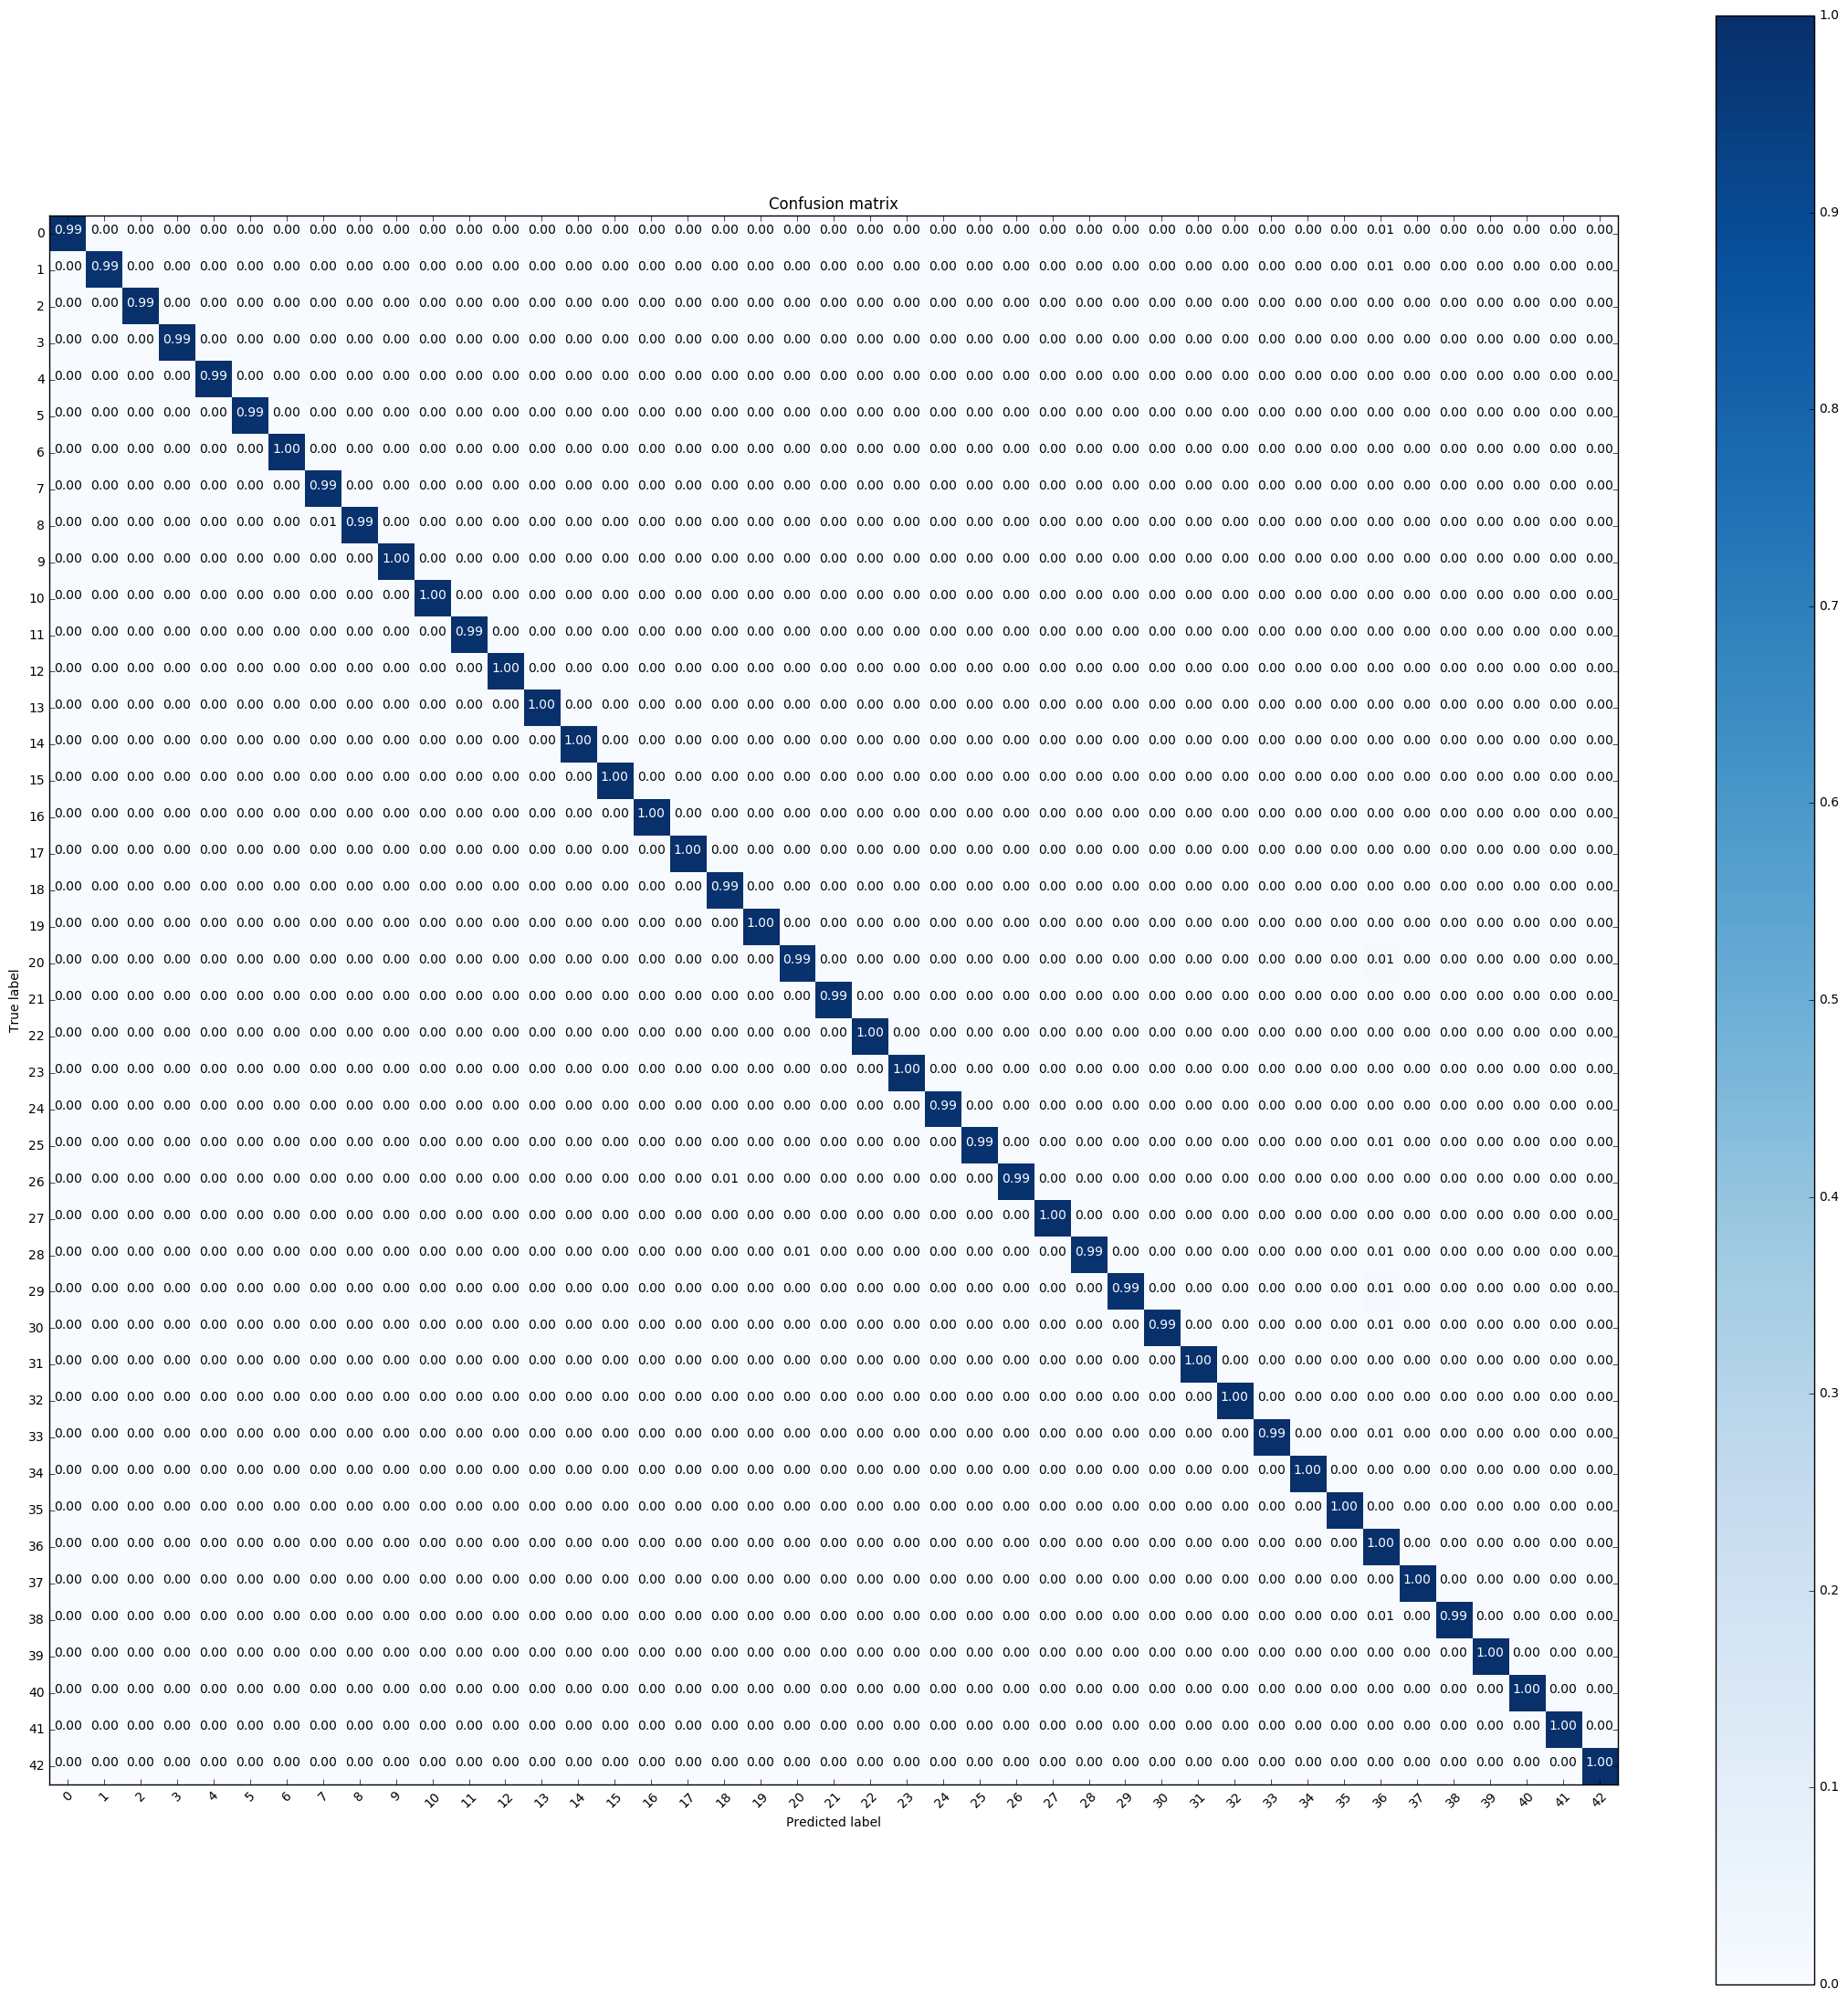

In [32]:
# Confusion Matrix Evaluation

def confusion_matrix(labels, pred, num_classes):
    cm = np.zeros([num_classes, num_classes])
    for l,p in zip(labels, pred):
        cm[l,p] += 1
    s = np.sum(cm, axis=1)
    r = cm / s.reshape([len(s),1])
    return r
    
# Borrowed from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f" % cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
prediction_labels = model.eval_prediction_labels(session, X_test_norm)
print("prediction_labels =", prediction_labels)

cm = confusion_matrix(y_test, prediction_labels, model.config.num_classes)
    
plt.figure(figsize=(22,22))
plot_confusion_matrix(cm, classes=range(model.config.num_classes),
                      title='Confusion matrix')

In [20]:
# plt.figure(figsize=(22,22))
print("len =", len(y_test))
print("matches =", np.sum(prediction_labels == y_test))
# plot_confusion_matrix(cm, classes=range(model.config.num_classes),
#                       title='Confusion matrix')

len = 25800
matches = 25670


In [21]:
# print(prediction_labels[:20])
# print(y_test[:20])

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

For training batch_size=128 was used with epochs=55, learning rate exponentially decayed starting from 0.01 and coeeficient 0.95 which applied after each epoch.

Some runs were stucked in local minimum and learning flattened in that case I restarted learning. For the model with additional generated images dataset i've trainied it first for 35 epochs and additionally trainied it for another 20 epochs in two runs using starting learning rate 0.01 and 0.001 for each run respectively.

Final best Accuracy **99.34%** on test dataset was achieved on a model trained on a dataset with additional generated images.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

Not sure what this question exactly about. But there was some problem during working on this lab.
1. Vanishing gradient due to missing normalization when I first tried convolutional model after simple softmax classifier. BTW, I've tried also a simple softmax classifier with just one input layer connected directly to output and applied to the original dataset without any processing (except grayscaling input) gave me Accuracy=88.6% - not as good but still much better than random.
2. Debugging is hard. When something is not working and you see a loss stucked on a plato this is the problem. I've debugged each layer, each activation by just outputing values (with batch_size=1 and `break` after each or several iteration) and in that way I saw that my predictions are just becoming 7:) and then my logits was exploding to hundreds and thousands.
<img src="imgs/seven.png"/>
3. Saving/Restoring model params after learning and applying additional round of learining helps to push model to better results. Below is a screenshot of results of such additional training:
<img src="imgs/35_plus10_epochs.png"/>
### And additional training for 10 epochs from 45 to 55 total:
<img src="imgs/45_plus10_epochs.png"/>

Looks like it's possible to train further for another 10-20 epochs and potentially increase accuracy to another 0.1-0.3% or even more. (After spending yet another 10 epochs it seems that 99.34% is a limit so far ...)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

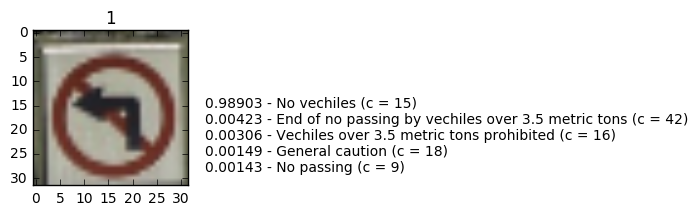

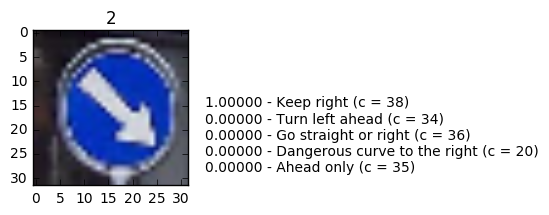

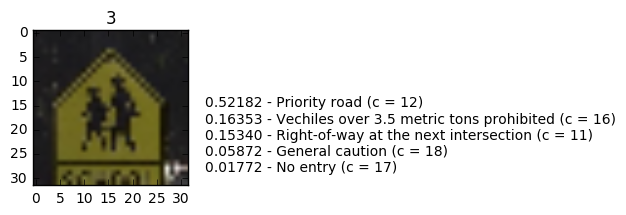

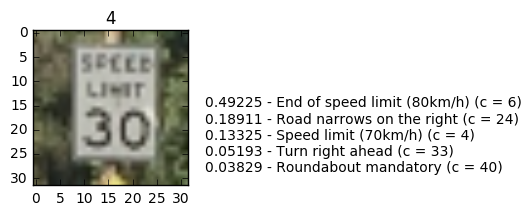

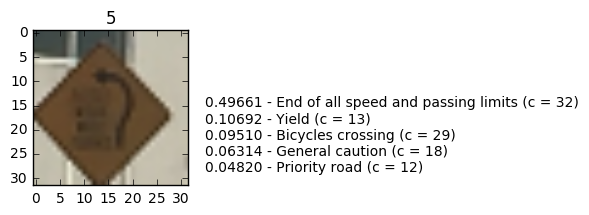

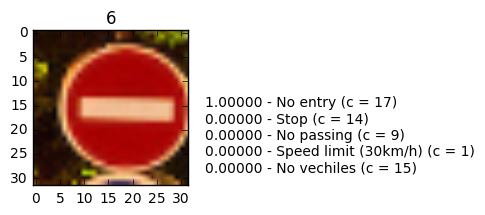

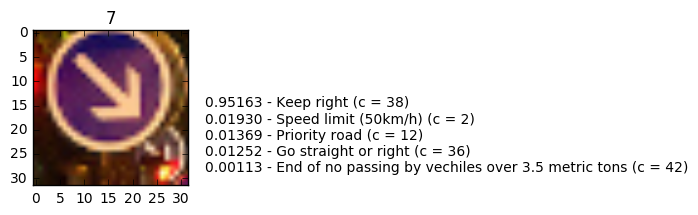

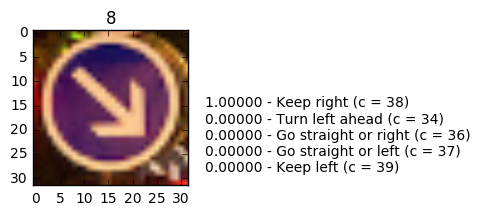

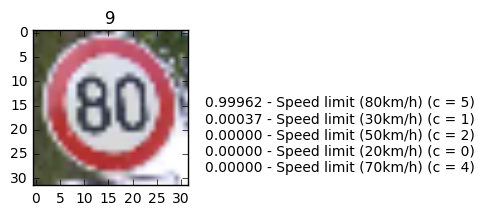

In [33]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def resize_image(img):
    im = cv2.resize(img, (32,32))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(resize_image(img))
    return np.array(images)

# Load images from folder "test_imgs"
imgs = load_images_from_folder('test_imgs')

# Prepare inputs by normalization
imgs_norm = normalize(imgs)

# Infer mode of the model with top_k
vals, imgs_pred_labels = model.eval_prediction_labels_k(session, imgs_norm, k=5)
# print("imgs_pred_labels =", imgs_pred_labels)
# print("vals =", vals)


# Visualize results
num = 0
for idx, val, im in zip(imgs_pred_labels, vals, imgs):
    num += 1
    plt.figure(figsize=(2,2))
    plt.imshow(im)
    plt.title(num)
    text = []
    for i,v in zip(idx, val):
        text.append("%.5f - %s (c = %d)\n" % (v, signnames[i], i))
    plt.text(35, 32, "".join(text))




### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I've intentionally selected images that are not in present classes (images # 1,3,4,5 above) and images that model should be able recognize (images # 2, 6, 7, 8, 9).

As expected model can't recognize newly presented images that doesn't belong to any classes but still interesting to see what model is thinking about them. Like the image # 1 was recognized as No Vehicles (c = 15) with probalility 99.96% 

As for the images from known classes we see that model classified them well. With one exception on image # 7 sign Keep Right was cropped a bit low thus cutting the top edge of the circle and I think this is preventing model to make a correct prediction (update: after another 10 epochs it learned to recognize it correctly). But when I changed the crop area and made full circle fit into the image (image # 8) model recognized this sign correctly.

Another interesting was observed on an image # 9 - Speed Limit 80 km/h. Firstly model that was trained on original images without adding new generated image was not able to recognized this sign and classified it as Speed Limi 30km/h which is not bad because they are quite similar. But after adding generated images to the train dataset model was able to recognize it correcly.

In [23]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

## Prediction and output is already above for test images from folder "test_imgs"

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [24]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# Confusion matrix on a test dataset was calculated earlier.

Confusion matrix of model predictions calculated and visualized earlier on a test dataset. As we can see model learned well and shows accuracy in 99.26% on test image dataset. 


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

Please read answer above for Question # 6

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

Place any squared images into the folder "test_imgs" and run code under the block Step 3 -> Implementation (also it's a good idea to run all code above too).

You cun re-run the whole notebook it will not take long time because model is loading from pre-trained params and the most complex part probably is additional image generation that take around 1 minute on MacBook Pro 13-inch.

That wasn't an easy lab because it took a lot of time to write and test all code needed for analyzing results and making tests. But is was fun and I feel that is always more improvement that can be done here. Like:
- Add another fully connected layer to the model after convolutional layer so to have conv1 -> conv2 -> fully connected 1 -> fully connected 2
- Improve training by checking changes in Validation loss and halt training early without calculating all epochs if validation loss is not decreasing anymore.
- Save parameters after each epoch and after training select those that has the lowest Validation Loss that just the last params.

Will be glad to hear any feedback on my work. Hope all my research is enough to pass this lab and I can continue with further lectures %) 

Thanks!

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.